In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 5

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
train_e2e_loss_fn = compose(train_loss_fn, compute_end_to_end)
test_e2e_loss_fn = compose(test_loss_fn, compute_end_to_end)

## Original wide network

In [3]:
depth = 3
init_type = "orth"
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

step_size = 5e3
n_outer_loops = 5000
n_inner_loops = 100

In [4]:
tol = 1e-10
orig_step_size = step_size
orig_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=orig_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True,
    test_e2e_loss_fn=test_e2e_loss_fn
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Compressed network

In [5]:
V = compute_factor(init_weights=init_weights, e2e_loss_fn=train_e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [6]:
prop = 0
tol = 1e-14
comp_step_size = [prop * step_size] + (depth * [step_size]) + [prop * step_size]
no_dlr_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True,
    test_e2e_loss_fn=test_e2e_loss_fn
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
prop = 0.01
comp_step_size = [prop * step_size] + (depth * [step_size]) + [prop * step_size]
tol = 1e-13
comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True,
    test_e2e_loss_fn=test_e2e_loss_fn
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
orig_weights = orig_result['weights']
comp_weights = comp_result['weights']
no_dlr_weights = no_dlr_result['weights'][:300]
orig_end_to_end = [compute_end_to_end(w).reshape(-1) for w in orig_weights]
comp_end_to_end = [compute_end_to_end(w).reshape(-1) for w in comp_weights]
no_dlr_end_to_end = [compute_end_to_end(w).reshape(-1) for w in no_dlr_weights]

## 3d

In [ ]:
6, 20

In [81]:
A = jnp.linalg.svd(generate_data(key=PRNGKey(21), shape=(3, d*d)), full_matrices=False)[2]

In [82]:
red_orig_end_to_end = jnp.array([A @ w for w in orig_end_to_end])
red_comp_end_to_end = jnp.array([A @ w for w in comp_end_to_end])
red_no_dlr_end_to_end = jnp.array([A @ w for w in no_dlr_end_to_end])

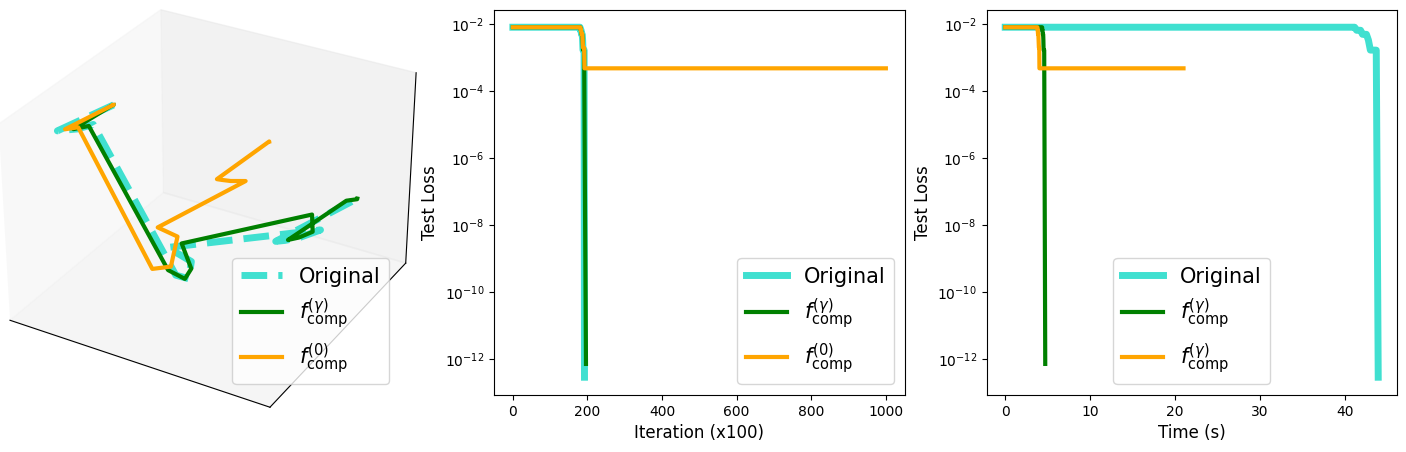

In [83]:
fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(131, projection='3d')

ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=5, c='turquoise', linestyle='--', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=3, c='green', linestyle='-', label=r'$f^{(\gamma)}_{\mathrm{comp}}$')
ax.plot(red_no_dlr_end_to_end[:, 0], red_no_dlr_end_to_end[:, 1], red_no_dlr_end_to_end[:, 2], linewidth=3, c='orange', linestyle='-', label=r'$f^{(0)}_{\mathrm{comp}}$')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.legend(fontsize=15)
ax.set_box_aspect(None, zoom=1.2)

ax = fig.add_subplot(132)

ax.semilogy(orig_result['test_loss'], linewidth=5, c='turquoise', label='Original')
ax.semilogy(comp_result['test_loss'], linewidth=3, c='green', label=r'$f^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['test_loss'], linewidth=3, c='orange', label=r'$f^{(0)}_{\mathrm{comp}}$')
ax.set_xlabel('Iteration (x100)', fontsize=12)
ax.set_ylabel('Test Loss', fontsize=12)
ax.legend(fontsize=15)

ax = fig.add_subplot(133)

ax.semilogy(orig_result['time'], orig_result['test_loss'], c='turquoise', linewidth=5, label='Original')
ax.semilogy(comp_result['time'], comp_result['test_loss'], c='green', linewidth=3, label=r'$f^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['time'], no_dlr_result['test_loss'], c='orange', linewidth=3, label=r'$f^{(\gamma)}_{\mathrm{comp}}$')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Test Loss', fontsize=12)
ax.legend(fontsize=15)

plt.savefig('figs/equiv_traj_mc.png', dpi=300, bbox_inches='tight')